# Data Exploration 
Now that we have the streamflow data imported as a CSV file, we move on to the next step in the analytical workflow, namely exploring the data. After we read the data in CSV file back into our session, we will repeat the exploratory analyses we did in Unit1 with Excel:

* Create some scatter plots of the entire dataset as well as for the pre- and post-Falls lake years.


* Deriving some new column in our data frame from existing columns:
 * Create `year` and `month` columns from our `datetime` data
 * Create a `water_year` column based on year and month values
 * Convert our *cfs* data into *cms* and *mgd* units and re-plot


* Summarize the data by *confidence codes*:
 * Group the data by data-value qualification (i.e., "confidence") codes
 * Determine how many different codes exist in our data and what those codes are
 * Compute the number of records in each code
 * Create a quick bar pot showing the record count in each category


* Compute summary statistics of the entire set of discharge data.
 * Compute min, max, mean, median, as well as specific quantiles.
 * Plot these values
 * Repeat for select years of data (pre- and post- Falls Lake construction)

## ♦ Import libraries
First, we need to load a few Python packages build for data analyisis projects. We'll grab familiar `pandas`, but also `matplotlib` a widely-used plotting library, and it's companion `seaborn` which facilitates some plotting operations. 

In [1]:
#Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Instruct Jupyter to allow plots in the document itself
%matplotlib inline

## ♦ Read the data into a *Pandas* dataframe.
Read in the CSV created in the previous notebook into a new Pandas dataframe named `df`. We'll also force the data type of the `site_no` field to be a *string*, not a *number*, which Pandas would infer by default...

In [3]:
#Load the saved csv file, reading the site_no column as a string, not a number.
df = pd.read_csv('GageData.csv', dtype={'site_no':'str'}) 

In [4]:
#Confirm it looks good by viewing the first 5 records using the "head()" function
df.head()

agency_cd   site_no    datetime  MeanFlow_cfs Confidence
0      USGS  02087500  1930-10-01         347.0          A
1      USGS  02087500  1930-10-02         173.0          A
2      USGS  02087500  1930-10-03         132.0          A
3      USGS  02087500  1930-10-04         125.0          A
4      USGS  02087500  1930-10-05         125.0          A

### ○ Data types
Dataframes are structured so that each column contains values of a constant and defined **data type**. Typical data types in a Pandas dataframe include integers (`int64`), floating point numbers (`float64`), strings (`object`), and date/time objects (`datetime64`).

If we import data into a dataframe, it infers data types from the the values in the input file unless we override the defaults, as we did above with the `site_no` varible. We can view the datatypes in a dataframe via the dataframe's `dtypes` property:

In [5]:
#Show the data types of each column
df.dtypes

agency_cd        object
site_no          object
datetime         object
MeanFlow_cfs    float64
Confidence       object
dtype: object

Note that the `datetime` variable has an incorrectly assigned data type. It is listed as a string (`object`), so we need to re-define it to be a `datetime64` object, specifying the date format our data use.

In [6]:
#Convert datetime to an actual datetime object
df['datetime'] = pd.to_datetime(df['datetime'],format=('%Y-%m-%d'))
df.dtypes

agency_cd               object
site_no                 object
datetime        datetime64[ns]
MeanFlow_cfs           float64
Confidence              object
dtype: object

### ○ Indexes and data slices
Dataframe *indexes* provide different ways to select, sort, and organize data **rows**. By setting our `datetime` field as an index, we can then select rows by date ranges or **"slices"**. 

In [7]:
#Setting the date time as the index allows time slicing
df.set_index('datetime',inplace=True)

In [8]:
#Create two new dataframe views: One with records before Falls Lake an one after
dfPre = df.loc['1930-01-01':'1979-12-31']
dfPost = df.loc['1984-01-01':'2017-12-31']

--Some commands to explore a data slice: uncomment each and run this code block--

In [9]:
#dfPost.head()
#dfPost.shape
#dfPost.columns
#dfPost['MeanFlow_cfs'].max()

## ♦ Deriving new columns 
We'll want to add a few new columns to our dataset to faciliate analysis. These include:
* `MeanFlow_cms` - mean flow, converted from  $ft^3/s$ to $m^3/s$ (1 cfs = 0.028316847 cms)
* `MeanFlow_mgd` - mean flow, converted from $ft^3/s$ to $MGal/day$ (1 cfs = 0.6464 mgd)
* `year` - The year of the record, extracted from the datetime field
* `month` - The month of the record, extracted from the datetime field
* `water_year` - The water year of the record which extents from Oct. (of the previous year) thru Sept.

And finally, we'll add a column named `status` which will indicate whether the record was collected before construction of Falls Lake (before 1980) or after its completion (after 1984). We could continue to use date slices to compare and plot flow before/after the dam was placed, but creating a new column is more in tune with the "tidy data" concept and will facilitate analysis and plots later... 

#### Creating new flow columns: `MeanFlow_cms` and `MeanFlow_mgd`
* Converting flow units is relatively easy as we just multiply an entire column by the conversion factor...

In [10]:
#Create a column of flow in cubic meters per second
df['MeanFlow_cms'] = df['MeanFlow_cfs'] * 0.028316847

* <mark>Now you try it with mgd</mark> `(1 cfs = 0.6464  mgd)`

In [11]:
#Create a column of flow in cubic meters per second
df['MeanFlow_mgd'] = 

#### Deriving `year` and `month` columns from the `datetime` index
* Creating the year and month columns isn't an arithmetic expression, but rather a data type conversion one. The functions `.year` and `.month` on a datetime object extract the year and month, respectively. 

In [12]:
#Extract the year from the datetime index
df['year'] = df.index.year

* <mark>Now see if you can create the `month` column...</mark>

In [13]:
#Extract the month from the datetime index


#### Deriving the `water_year` column from the `year` and `month` data. 
Water year begins in October. Therefore it equals the calendar year for months prior to October, but for October, November, and December, it takes the value of the following year. 

There are two methods for computing water year. Both yield the exact same results but show different data techniques using Pandas. 

##### ♦ <u>Method 1</u> for computing water year: computing values on filtered records
In the first method, we add a new column `water_year` to our data frame, setting its default value to the value in the `year` column. Then we filter for records where the month is >= 10 and revise the value in `water_year` column to be `year + 1`.

In [14]:
#Create a new column, setting all its values the same as the year column
df['water_year'] = df['year']

In [15]:
#Create a mask of just records with months from Jan thru Sept (i.e. < 10)
monthMask = df['month'] >= 10

In [16]:
#Apply this mask to create a view of just records from Jan thru Sept
df.loc[monthMask, 'water_year'] = df['year'] + 1

In [17]:
#Have a look at a few random records
df.sample(5)

agency_cd   site_no  MeanFlow_cfs Confidence  MeanFlow_cms  \
datetime                                                                
1964-04-07      USGS  02087500        1320.0          A     37.378238   
1970-06-27      USGS  02087500         274.0          A      7.758816   
2015-05-07      USGS  02087500        1140.0          A     32.281206   
1992-09-14      USGS  02087500         274.0          A      7.758816   
1965-12-22      USGS  02087500         234.0          A      6.626142   

            MeanFlow_mgd  year  month  water_year  
datetime                                           
1964-04-07      853.2480  1964      4        1964  
1970-06-27      177.1136  1970      6        1970  
2015-05-07      736.8960  2015      5        2015  
1992-09-14      177.1136  1992      9        1992  
1965-12-22      151.2576  1965     12        1966

##### ♦ <u>Method 2</u> for computing water year: using a `lambda` function
In this approach, we loop through all records and apply a "lambda" function on each. In this lambda function, the value of "x" is taken from the `datetime` column and the output of the function is passed into the `water_year2` column.

In [18]:
#Use a lambda function to assign values to water_year2 based on datetime values
df['water_year2'] = df[['year','month']].apply(
    lambda row: row['year'] if row['month'] < 10 else row['year'] + 1, 
    axis = "columns")

In [19]:
#Show the results; water_year and water_year2 are the same...
df.sample(10)

agency_cd   site_no  MeanFlow_cfs Confidence  MeanFlow_cms  \
datetime                                                                
1945-09-30      USGS  02087500         887.0          A     25.117043   
2003-01-22      USGS  02087500         450.0          A     12.742581   
2016-11-22      USGS  02087500         290.0          A      8.211886   
1983-09-07      USGS  02087500         132.0          A      3.737824   
1954-12-17      USGS  02087500        1220.0          A     34.546553   
1955-01-09      USGS  02087500         319.0          A      9.033074   
1941-12-18      USGS  02087500         216.0          A      6.116439   
2016-02-26      USGS  02087500        3630.0          A    102.790155   
1977-02-22      USGS  02087500         415.0          A     11.751492   
1957-03-20      USGS  02087500        1120.0          A     31.714869   

            MeanFlow_mgd  year  month  water_year  water_year2  
datetime                                                        
1945-09-30      573.3568  1945      9        1945         1945  
2003-01-22      290.8800  2003      1        2003         2003  
2016-11-22      187.4560  2016     11        2017         2017  
1983-09-07       85.3248  1983      9        1983         1983  
1954-12-17      788.6080  1954     12        1955         1955  
1955-01-09      206.2016  1955      1        1955         1955  
1941-12-18      139.6224  1941     12        1942         1942  
2016-02-26     2346.4320  2016      2        2016         2016  
1977-02-22      268.2560  1977      2        1977         1977  
1957-03-20      723.9680  1957      3        1957         1957

In [20]:
#Drop the water_year2 column, now that the demonstration is over...
df.drop("water_year2",axis='columns',inplace=True)

#### Deriving the `status` column with values indicating whether the record was recorded before or after Falls Lake construction.
Lastly, we'll create our status column with two values: `Before FL` for records before 1980, and `After FL` for records after 1984. We do this by calculating new values on slices of rows, using dates to create the slices.

In [21]:
#Assign records collected before 1980 a status of "Before FL"
df.loc['1930-01-01':'1979-12-31','status'] = "Before FL"
#Assign records collection after 1984 a status of "After FL"
df.loc['1984-01-01':'2017-12-31','status'] = "After FL"
#Show a random sample of the dataframe
df.sample(10)

agency_cd   site_no  MeanFlow_cfs Confidence  MeanFlow_cms  \
datetime                                                                
1931-08-14      USGS  02087500        4160.0          A    117.798084   
1987-05-18      USGS  02087500         367.0          A     10.392283   
1989-12-05      USGS  02087500         446.0          A     12.629314   
1973-10-11      USGS  02087500         152.0          A      4.304161   
1986-11-07      USGS  02087500         218.0          A      6.173073   
1978-10-02      USGS  02087500         368.0          A     10.420600   
1964-07-28      USGS  02087500         228.0          A      6.456241   
2001-01-09      USGS  02087500         392.0          A     11.100204   
1946-09-04      USGS  02087500         247.0          A      6.994261   
1968-07-24      USGS  02087500         240.0          A      6.796043   

            MeanFlow_mgd  year  month  water_year     status  
datetime                                                      
1931-08-14     2689.0240  1931      8        1931  Before FL  
1987-05-18      237.2288  1987      5        1987   After FL  
1989-12-05      288.2944  1989     12        1990   After FL  
1973-10-11       98.2528  1973     10        1974  Before FL  
1986-11-07      140.9152  1986     11        1987   After FL  
1978-10-02      237.8752  1978     10        1979  Before FL  
1964-07-28      147.3792  1964      7        1964  Before FL  
2001-01-09      253.3888  2001      1        2001   After FL  
1946-09-04      159.6608  1946      9        1946  Before FL  
1968-07-24      155.1360  1968      7        1968  Before FL

---
## ♦ Explore the data: Plotting
As we did with Excel, we'd want to explore and examine our data for gaps or outliers. The two approaches for exploring data are to **visualize** the data (e.g. through plots etc.) and to **summarize** our data, both of which might expose odd values or trends in our data.  We'll begin with the former, examining various ways to plot data in Python. Pandas has some plotting capability that will examine. However, we'll also explore the *matplotlib* package, a powerful plotting package that has both Python and R versions, as well as *seaborn* which adds nice aesthetics to our plots. 

#### Create a simple plot using `Pandas` functionality. 
The Pandas library includes some plotting functionality, making it quite easy to generate a limited number of figures from our data. For more information see <br>https://pandas.pydata.org/pandas-docs/stable/visualization.html

* First let's look at the defaul plot, which is a line plot. We specify the value we want to plot, `MeanFlow_cfs`, and without specifying another axis, it uses the index as the independent variable, which in our case is the `datetime` values.

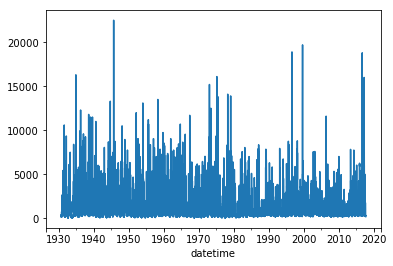

In [22]:
#Plot using Pandas
df['MeanFlow_cfs'].plot();

* Now let's look at **box plots**:https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.boxplot.html. <br>First we'll look at a box plot of all the flow data...

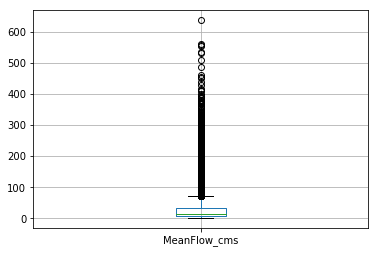

In [23]:
#Create a box and whiskers plot of our MeanFlow_cms values
df.boxplot('MeanFlow_cms');

 * Now box plots of flow, separated by status 

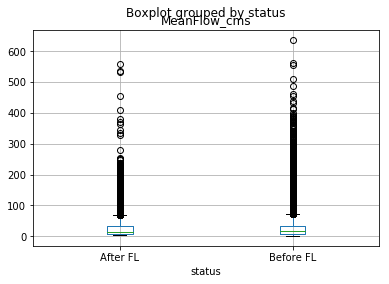

In [24]:
#Create a box and whiskers plot of our MeanFlow_cms values, broken by status
df.boxplot('MeanFlow_cms',by='status');

* <mark>Now see if you can produce a box plot of flow data by *month*</mark>

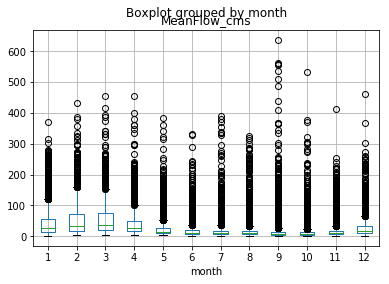

* <mark>**CHALLENGE**: See if you can produce the above plot, but just for data after 2010</mark><br>Hint: you might want to involve your index...

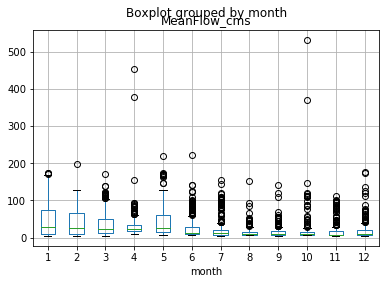

#### Use *ggplot* to plot
An alternative to Pandas built-in plotting capability is [`ggplot`](http://ggplot.yhathq.com/) which is similar, but not idential to R's ggplot. 

In [27]:
#Import everything from ggplot
from ggplot import *

C:\Users\jpfay\AppData\Local\conda\conda\envs\datadevil\lib\site-packages\ggplot\utils.py:66: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\jpfay\AppData\Local\conda\conda\envs\datadevil\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\jpfay\AppData\Local\conda\conda\envs\datadevil\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [28]:
#Let's bring back our datetime values from index to a column in our dataframe
df['datetime'] = df.index.values

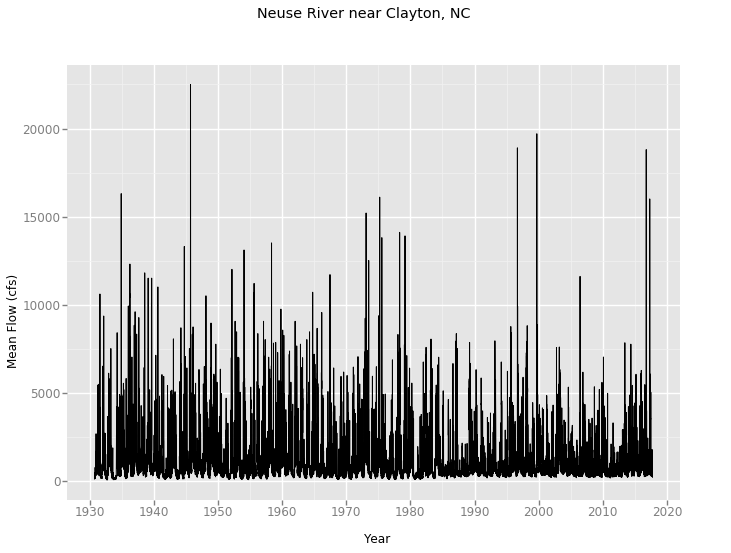

<ggplot: (-9223371861206888353)>

In [29]:
#Plot using aesthetics
ggplot(aes(x='datetime',y='MeanFlow_cfs'), data = df) +\
    geom_line() +\
    xlab("Year")  +\
    ylab("Mean Flow (cfs)") +\
    ggtitle("Neuse River near Clayton, NC")

#### Create a time series plot of mean discharge using `matplotlib`
**Matplotlib** has been described as "the grandfather of plotting" in Python ([source](http://pbpython.com/visualization-tools-1.html)), borrowing much technique (and syntax) from Matlab. It's not the most friendly, but it does a lot and is worth getting the feel for. 

We'll go deeper into visualization tools in the next unit, but we'll examine some examples to get the gist. Meanwhile, more documentation can be found here:<br>
https://matplotlib.org/devdocs/api/pyplot_summary.html

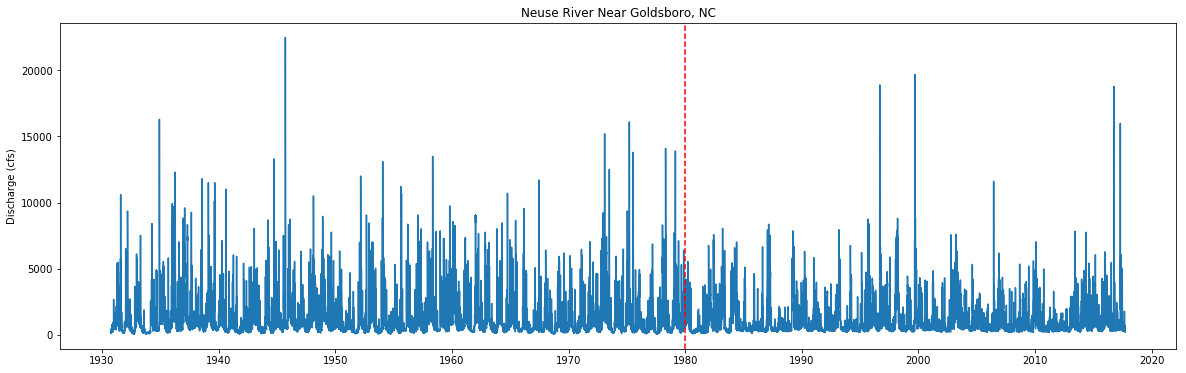

In [30]:
#Create a plot canvas of a specified size
plt.figure(figsize=(20,6));

#Plot the mean flow (against time)
plt.plot(df['MeanFlow_cfs']);

#Add a vertical line indicating when Falls Lake construction began
plt.axvline(x='1980-01-01',color='red',ls='--');

#Add some aesthetics
plt.title("Neuse River Near Goldsboro, NC");
plt.ylabel("Discharge (cfs)");

#### Invoke `Seaborn` to make prettier plots 
https://seaborn.pydata.org/tutorial/aesthetics.html


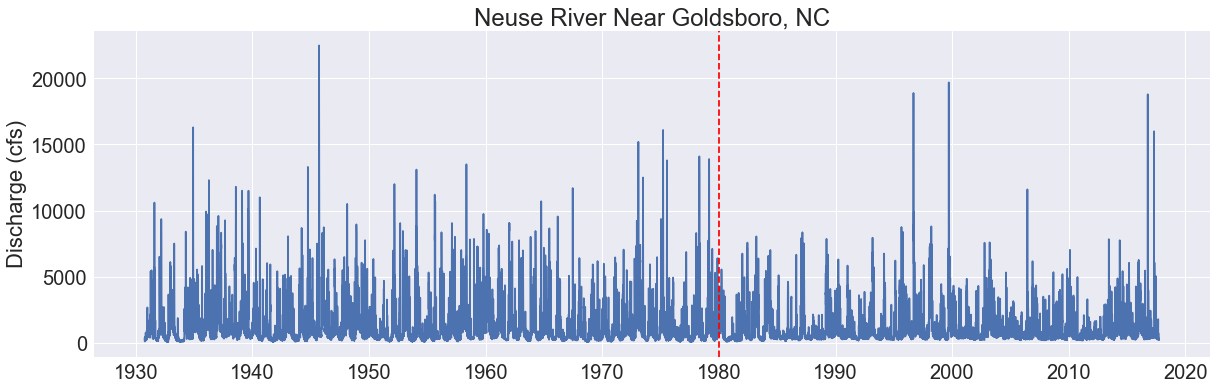

In [31]:
#Activate seaborn default aesthetics
sns.set(font_scale=2)
#Repeat above
plt.figure(figsize=(20,6));
plt.plot(df['MeanFlow_cfs']);
plt.axvline(x='1980-01-01',color='red',ls='--');
plt.title("Neuse River Near Goldsboro, NC");
plt.ylabel("Discharge (cfs)");

### Create a plot of all data, superimposed with the pre- and post-Falls Lake data views


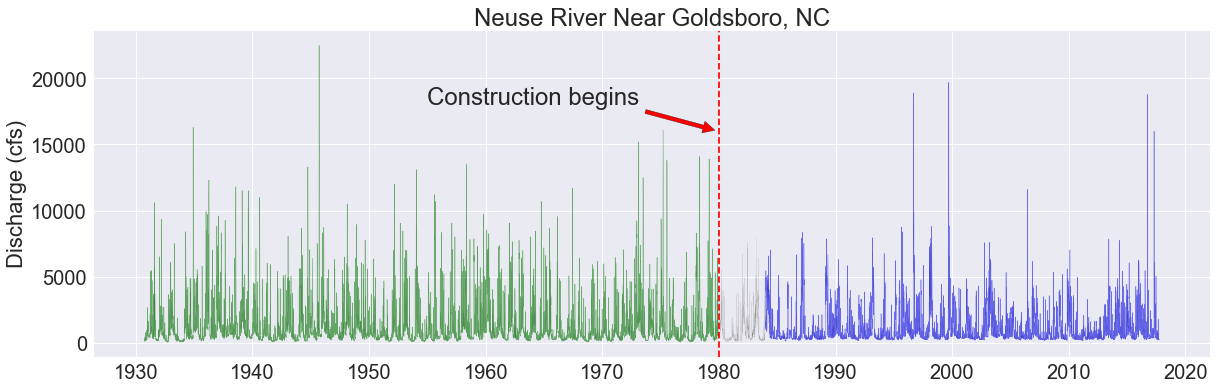

In [32]:
#Create the canvas
plt.figure(figsize=(20,6))

#Add plot lines for the entire dataframe, then the two dataframe subsets
plt.plot(df['MeanFlow_cfs'],color='grey',linewidth=0.1) 
plt.plot(dfPre['MeanFlow_cfs'],color='green',alpha=0.5,linewidth=0.5)
plt.plot(dfPost['MeanFlow_cfs'],color='blue',alpha=0.5,linewidth=0.5)

#Add the aesthetics
plt.axvline(x='1979-12-31',color='red',ls='--')
plt.title("Neuse River Near Goldsboro, NC")
plt.ylabel("Discharge (cfs)");
plt.annotate('Construction begins',
             xy=('1980',16000),
             xytext=('1955',18000),
             arrowprops=dict(facecolor='red',shrink=0.05))

#Show the plot
plt.show;

### Converting cubic feet/second to cubic *meter*/second

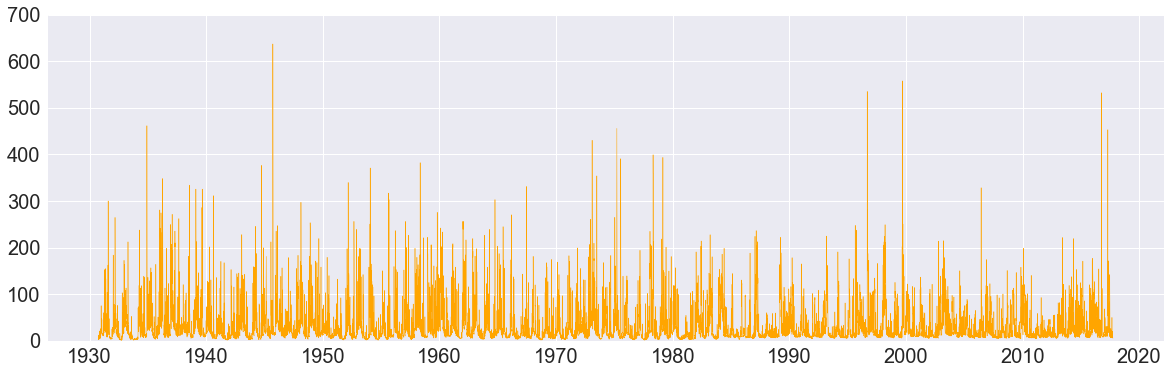

In [33]:
#Replot (this time in a thinner, orange line)
plt.figure(figsize=(20,6));
plt.plot(df['datetime'],df['MeanFlow_cms'],linewidth=0.5,color='orange')
plt.ylim((0,700))
plt.show;

* <mark> See if you can repeat the plot above, but set the units to `mgd`, make the line `green`, and set the x limit to show just from `1984-01-01` to `2010-01-01`</mark>

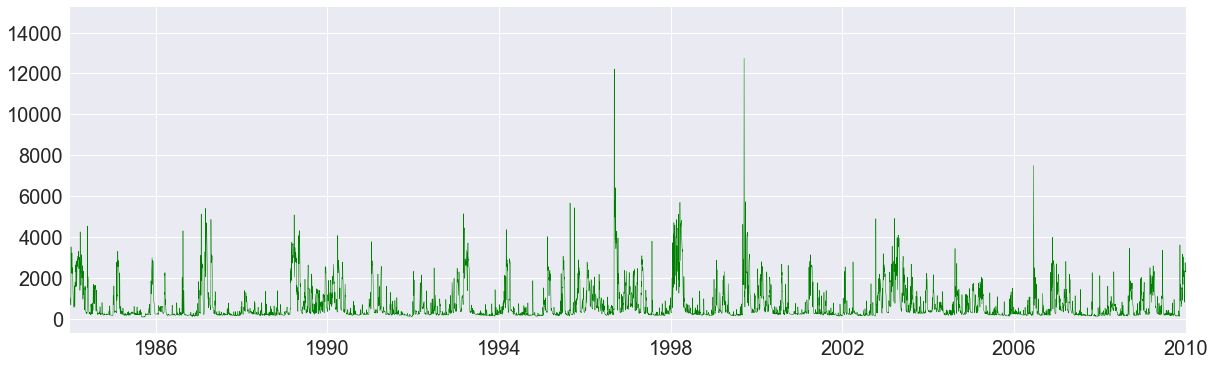

In [37]:
#Replot: modify the commands below..
plt.figure(figsize=(20,6));
plt.plot(df['datetime'],df['MeanFlow_cms'],linewidth=0.5,color='orange')
plt.ylim((0,700))
plt.show;

## ♦ Explore the data: Summarizing
The alternative to plotting to explore the data is to summarize. Here we'll examine how to examine properties of our dataset as a whole and also how to group our data and examine summaries by those groupings.

### First we'll examine a few basic properties of our dataframe

In [38]:
#Get a count of all records from the dataframe's shape (rows, columns)
df.shape

(31777, 11)

In [39]:
#Or just show the rows, i.e., the first item in the shape result
df.shape[0]

31777

In [40]:
#We can also use the Python `len` command to show the "lenght" of the dataframe
len(df)

31777

### Summarizing/grouping records by Confidence code
Here, we group the data by the unique values in a column, namely the `Confidence` column. First, we'll just examine the number of unique values and what those values are. 

In [41]:
#Use nunique on the column to list the number of unique values
print(df['Confidence'].nunique())

2


In [42]:
#Use unique to show what the 4 unique values are
print(df['Confidence'].unique())

['A' 'A:e']


Now, we'll **group** the records by confidence codes

In [43]:
#Create the Pandas GroupBy object
grpConfidence = df.groupby(['Confidence'])

In [44]:
#We can now list the counts of records by confidence code
grpConfidence.count()

agency_cd  site_no  MeanFlow_cfs  MeanFlow_cms  MeanFlow_mgd  \
Confidence                                                                 
A               31635    31635         31635         31635         31635   
A:e               142      142           142           142           142   

             year  month  water_year  status  datetime  
Confidence                                              
A           31635  31635       31635   30174     31635  
A:e           142    142         142     142       142

In [45]:
#Or we can just show the count by a single column
grpConfidence['MeanFlow_cfs'].count()

Confidence
A      31635
A:e      142
Name: MeanFlow_cfs, dtype: int64

### Plot counts by confidence code
See: https://pandas.pydata.org/pandas-docs/stable/visualization.html

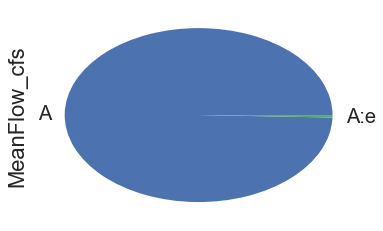

In [46]:
#Compute counts and plot them as a bar chart
count_by_Confidence = grpConfidence['MeanFlow_cfs'].count()
count_by_Confidence.plot(kind='pie');

### Generating summary statistics with `Describe`

In [47]:
#Summarize the MeanFlow_cfs data, using default outputs
df['MeanFlow_cms'].describe()

count    31777.000000
mean        31.460390
std         42.747088
min          1.274258
25%          8.523371
50%         14.866345
75%         33.980216
max        637.129057
Name: MeanFlow_cms, dtype: float64

In [48]:
#Summarize, **using our own percentiles**
summary_all = df['MeanFlow_cms'].describe(percentiles=[0.1,0.25,0.75,0.9])
summary_all

count    31777.000000
mean        31.460390
std         42.747088
min          1.274258
10%          5.889904
25%          8.523371
50%         14.866345
75%         33.980216
90%         83.251530
max        637.129057
Name: MeanFlow_cms, dtype: float64

In [49]:
#Group by the status values, and then describe..
df.groupby('status')['MeanFlow_cms'].describe(percentiles=[0.1,0.25,0.75,0.9])

count       mean        std       min       10%       25%  \
status                                                                   
After FL   12327.0  29.432437  36.775944  2.973269  7.249113  8.749906   
Before FL  17989.0  33.085121  46.825213  1.274258  4.955448  8.523371   

                 50%        75%        90%         max  
status                                                  
After FL   13.308918  32.847543  81.552519  557.841886  
Before FL  16.452088  34.263385  84.384204  637.129057

In [50]:
#Group by the status values, and then describe, and then TRANSPOSE for neater presentation
summary_bystatus = df.groupby('status')['MeanFlow_cms'].describe(percentiles=[0.1,0.25,0.75,0.9]).T
summary_bystatus

status      After FL     Before FL
count   12327.000000  17989.000000
mean       29.432437     33.085121
std        36.775944     46.825213
min         2.973269      1.274258
10%         7.249113      4.955448
25%         8.749906      8.523371
50%        13.308918     16.452088
75%        32.847543     34.263385
90%        81.552519     84.384204
max       557.841886    637.129057

In [51]:
#Concatenate (or join) the pre and post summary objects
dfSummary = pd.concat([summary_all, summary_bystatus],axis=1)
dfSummary.columns = ("1930-2017","1930-1980","1984-2017")
dfSummary

1930-2017     1930-1980     1984-2017
count  31777.000000  12327.000000  17989.000000
mean      31.460390     29.432437     33.085121
std       42.747088     36.775944     46.825213
min        1.274258      2.973269      1.274258
10%        5.889904      7.249113      4.955448
25%        8.523371      8.749906      8.523371
50%       14.866345     13.308918     16.452088
75%       33.980216     32.847543     34.263385
90%       83.251530     81.552519     84.384204
max      637.129057    557.841886    637.129057

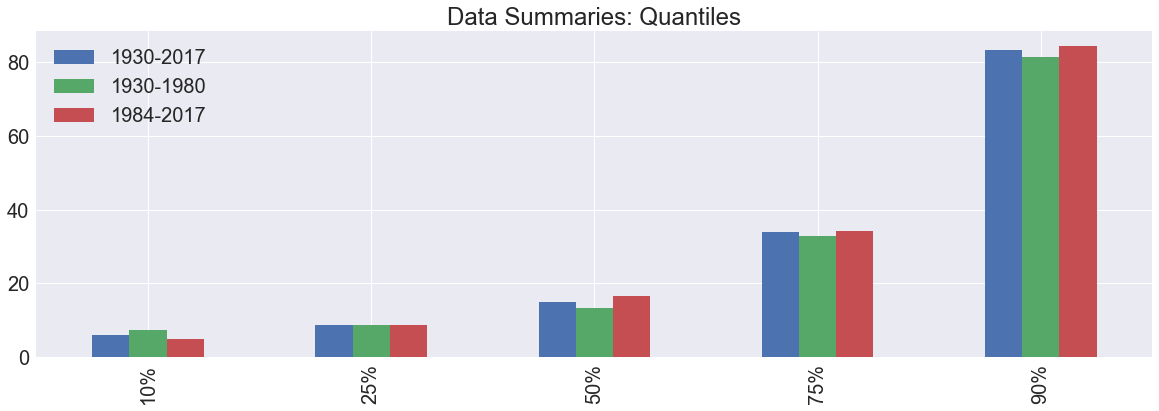

In [52]:
#Plot bar charts of the three summary tables
dfSummary[4:9].plot(kind='bar',
                    figsize=(20,6),
                    title="Data Summaries: Quantiles");

## Monthly plots
To produce monthly plots, we need to group our data by month, then plot. Grouping by month requires us to extract the month from the datetime column. 

In [53]:
byMonth = df.groupby('month')

In [54]:
monthlyDF = byMonth['MeanFlow_cfs'].mean()

In [55]:
monthlyDF

month
1     1606.355951
2     1874.735964
3     1965.260660
4     1581.829885
5      990.262885
6      757.114176
7      747.471635
8      724.722655
9      720.321456
10     629.731924
11     745.188889
12    1036.208380
Name: MeanFlow_cfs, dtype: float64

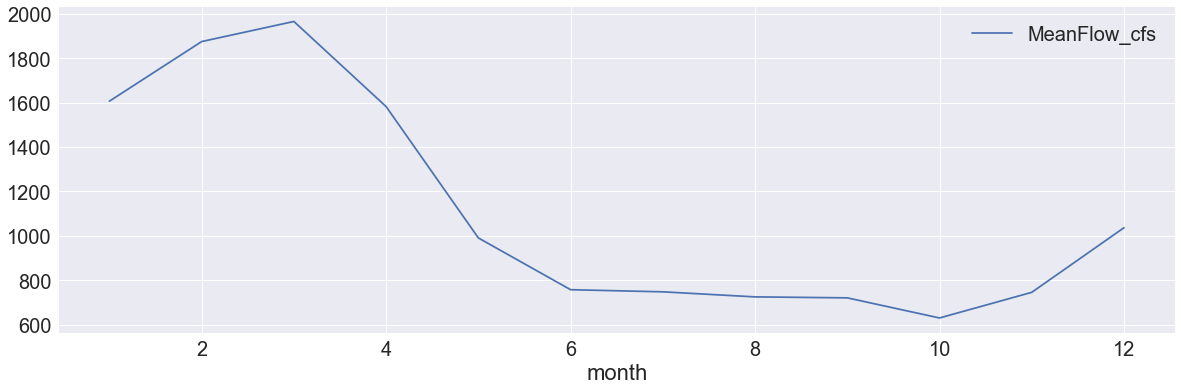

In [56]:
monthlyDF.plot(figsize=(20,6),legend=True);

### <mark>♦Exercise♦: Annual plots</mark>
 * Add a year column to your dataframe
 * Group by year
 * Compute the total (sum) annual discharge
 * Create a plot

In [ ]:
#Add a year column


In [ ]:
#Group by year


In [ ]:
#Compute total annual discharge


In [ ]:
#Plot
